## <b> Convolutional Neural Network for Brain Tumor Detection and Diagnosis (Pytorch, F1-score: 0.97) </b> 

In [1]:
!pip install split-folders
!pip install torch-summary

In [2]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = '''
div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s;
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s;
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s;
    border-top: 2px solid %s;
}

div.input_prompt {
color: %s;
}

div.output_prompt {
color: %s; 
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s;
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s;
}

.edit_mode div.cell.selected:before {
background: %s;
}

.edit_mode div.cell.selected {
border-color: %s;

}
'''

def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, 
                                            main_color,  main_color, prompt, main_color, main_color, 
                                            main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()


In [4]:
labels_df = pd.read_csv('/kaggle/input/brian-tumor-dataset/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [5]:
os.listdir('/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

In [6]:
labels_df.shape

(4600, 6)

In [7]:
# Dataset Path
data_dir = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/kaggle/working/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:40, 114.36 files/s]


## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b> 

In [8]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [9]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

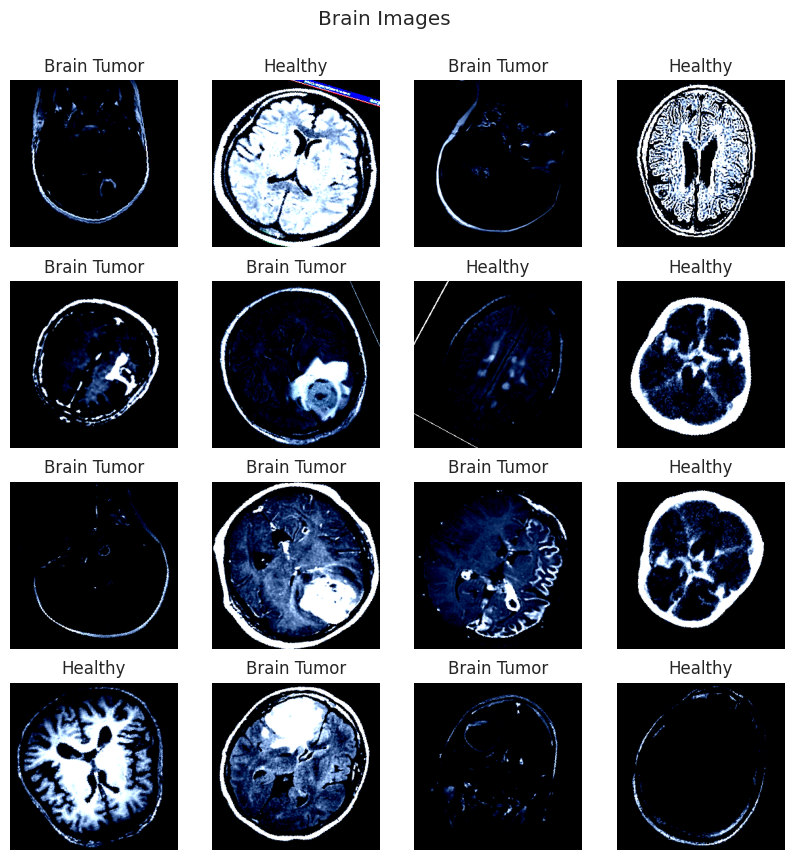

In [10]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [11]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [12]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [13]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [14]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [15]:
params_model={
        "shape_in": (3,256,256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [16]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

In [17]:
loss_func = nn.NLLLoss(reduction="sum")

In [18]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b> 

In [19]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [20]:
def Train_Val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [21]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

<Axes: >

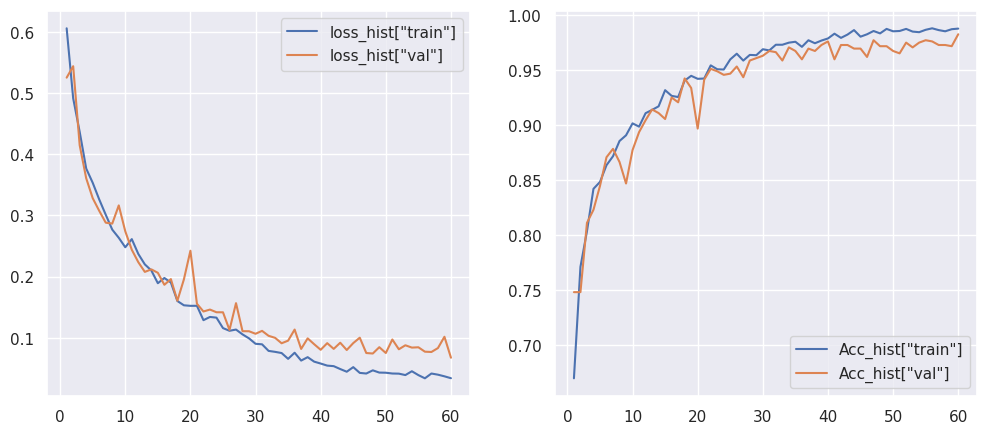

In [22]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

In [23]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       503
         1.0       0.98      0.98      0.98       418

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




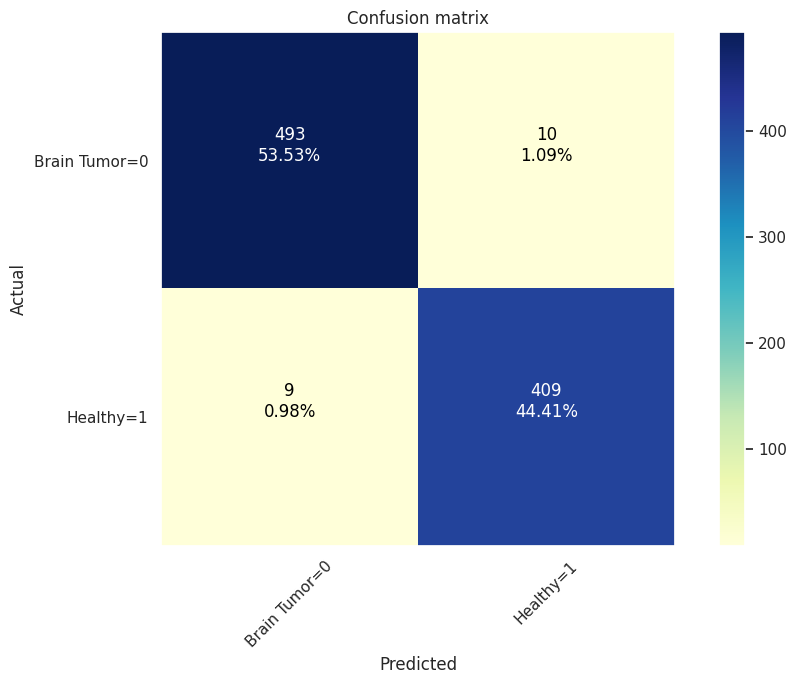

In [24]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [26]:
torch.save(cnn_model, "Brain_Tumor_model.pt")

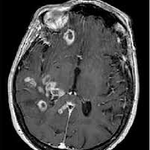

In [27]:
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
from IPython.display import display


data = np.ndarray(shape=(1,150, 150, 1), dtype=np.float32)
image = Image.open(f'/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg')
size = (150, 150)
image = ImageOps.grayscale(image)
image = ImageOps.fit(image, size, Image.LANCZOS)
image_array = np.asarray(image)
display(image)
#normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
data = image_array.reshape((-1,150,150,1))
#data[0] = normalized_image_array

In [29]:
prediction = cnn_model.predict(data)
print(prediction[0][0])

AttributeError: 'CNN_TUMOR' object has no attribute 'predict'